Implementation of Buffer ETF strategy pricer by Michael Liang and Daham Kim
* Step 1: import data and apply cubic interpolation on weekly IV
*  Step 2.1: create function cap_finder to calculate cap level for the buffer strategy knowing value ITM put + value ITM call + value cap = 0
  *  Step 2.2: Using Black-Scholes formula price options

* Step 3: Construct portfolio and backtest engine but first compute the daily return for buffer strat
* backtest for

* Step 4: Backtest on (60, 20,20 weight)
  * buffer level 5, 10, 15, 20%
  * option maturity 3, 6, 12 months









In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import yfinance as yf
import datetime as dt
from scipy.optimize import root_scalar
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import root_scalar


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
original_iv_call = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Buffer ETF - AM/wrds_option_call.csv') # Weekly Implied Volatility for call options
original_iv_put = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Buffer ETF - AM/wrds_option_put.csv')  # Weekly Implied Volatility for put options

In [4]:
#original_iv_call = pd.read_csv('/content/drive/MyDrive/wrds_option_call.csv') # Weekly Implied Volatility for call options
#original_iv_put = pd.read_csv('/content/drive/MyDrive/wrds_option_put.csv')  # Weekly Implied Volatility for put options

In [5]:
########
# Import market data such as SPY, AGG, fed fund rate, and implied volatility from WRDS and Yahoo Finance
#
########
spy = yf.Ticker('SPY')
spy_price = spy.history(period="10y").reset_index()
spy_price['Date'] = pd.to_datetime(spy_price['Date'])

# Calculate annual dividends by summing up the 'Dividends' column per year
spy_price['Year'] = spy_price['Date'].dt.year
annual_dividends = spy_price.groupby('Year').agg({'Dividends': 'sum'}).reset_index()

# Merge annual dividends with the SPY price data to calculate dividend yield
spy_price = spy_price.merge(annual_dividends, on='Year', suffixes=('', '_annual'))
spy_price['Div_yield'] = spy_price['Dividends_annual'] / spy_price['Close']
spy_price.drop(columns=['Year', 'Dividends_annual', 'Stock Splits', 'Capital Gains'], inplace=True)
spy_price.rename(columns={'Close':'SPY'}, inplace=True)
spy_price


# get AGG price from 2019 to 2024
agg = yf.Ticker('AGG')
agg_price = agg.history(period="10y")
agg_price.reset_index(inplace=True)
agg_price['Date'] = pd.to_datetime(agg_price['Date'])


# Calculate annual dividends by summing up the 'Dividends' column per year
agg_price['Year'] = agg_price['Date'].dt.year
annual_dividends = agg_price.groupby('Year').agg({'Dividends': 'sum'}).reset_index()


# Merge annual dividends with the AGG price data to calculate dividend yield
agg_price = agg_price.merge(annual_dividends, on='Year', suffixes=('', '_annual'))
agg_price['Div_yield'] = agg_price['Dividends_annual'] / agg_price['Close']
agg_price.drop(columns=['Year', 'Dividends_annual', 'Stock Splits', 'Capital Gains'], inplace=True)
agg_price

# reference article: Which Rate to use? by Tat Sang Fung
# Use repo rate (ie sofr rate)
# https://www.math.columbia.edu/~fts/What%20Rate%20to%20use%20v1.pdf

# dowload 13 week U.S. bill  rate data for option pricing
sofr_data = yf.Ticker("^IRX").history(period="10y")
# Access the interest rate data (usually in the 'Close' column)
sofr_data.reset_index(inplace=True)
sofr_data['Date'] = pd.to_datetime(sofr_data['Date'])
sofr_data.head()


# Convert 'Date' columns to date format
spy_price['Date'] = pd.to_datetime(spy_price['Date']).dt.tz_localize(None)
agg_price['Date'] = pd.to_datetime(agg_price['Date']).dt.tz_localize(None)
sofr_data['Date'] = pd.to_datetime(sofr_data['Date']).dt.tz_localize(None)
# Merge the DataFrames
market_data = pd.merge(sofr_data[['Date', 'Close']], spy_price[['Date', 'SPY', 'Div_yield']], on='Date')
market_data = pd.merge(market_data, agg_price[['Date', 'Div_yield']], on='Date', how='left', suffixes=('_spy', '_agg'))
market_data.rename(columns={'Close':'SOFR'}, inplace=True)
market_data['Date'] = pd.to_datetime(market_data['Date']).dt.date
# Display the merged DataFrame
market_data


,Date,SOFR,SPY,Div_yield_spy,Div_yield_agg
0,2014-11-24,0.005,173.757446,0.006532,0.007667
1,2014-11-25,0.018,173.631683,0.006537,0.007650
2,2014-11-26,0.010,174.075974,0.006520,0.007644
3,2014-11-28,0.005,173.707092,0.006534,0.007621
4,2014-12-01,0.007,172.499878,0.006580,0.007638
...,...,...,...,...,...
2511,2024-11-18,4.403,588.150024,0.008671,0.030691
2512,2024-11-19,4.408,590.299988,0.008640,0.030647
2513,2024-11-20,4.410,590.500000,0.008637,0.030678
2514,2024-11-21,4.413,593.669983,0.008591,0.030694


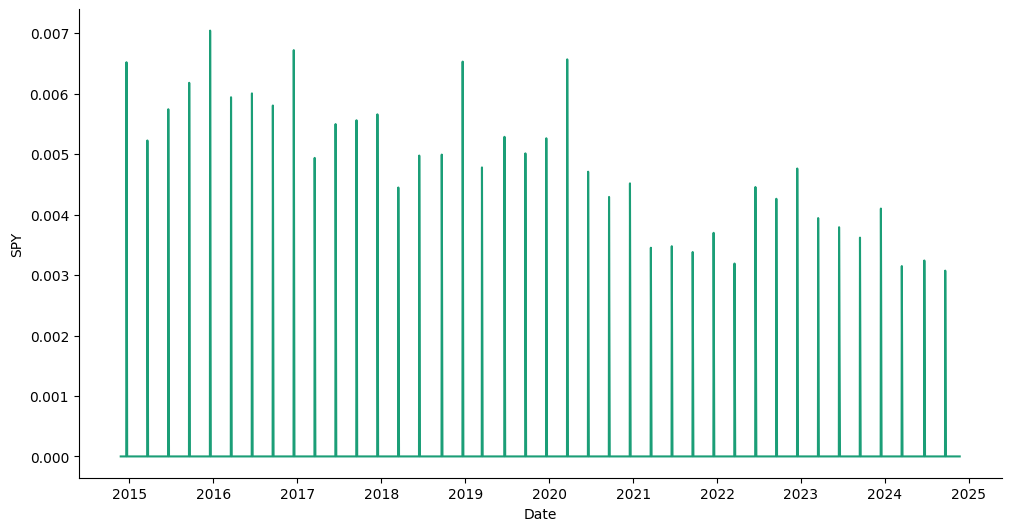

In [6]:

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Dividends']/series['SPY']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = spy_price.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('SPY')

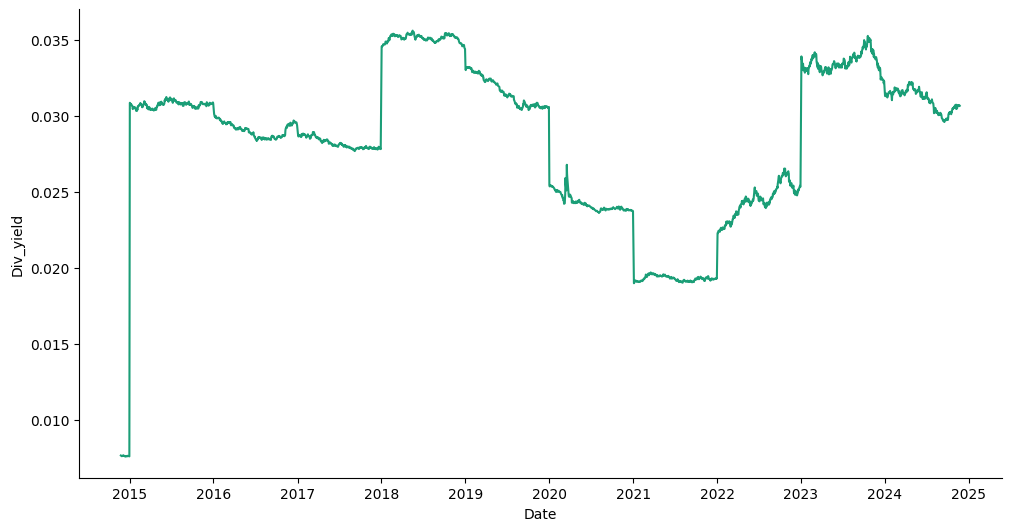

In [7]:

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Div_yield']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = agg_price.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Div_yield')

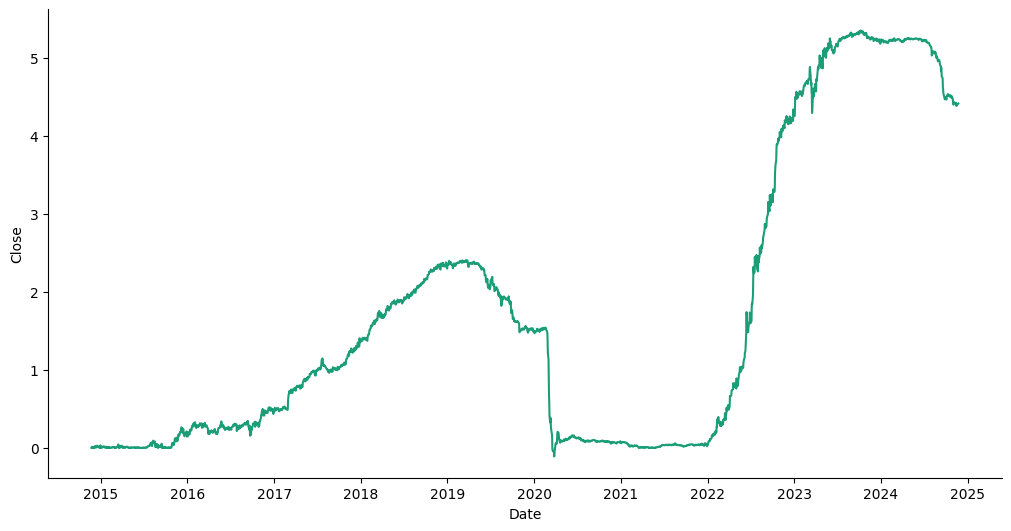

In [8]:

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['SOFR']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = market_data.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Close')

In [9]:
iv_call = original_iv_call
iv_put = original_iv_put

In [10]:

from scipy.interpolate import CubicSpline

# Assuming 'iv_call' is your DataFrame with columns: 'year', 'week', 'money', 'avg'

# Convert 'year' and 'week' into a 'date' column representing the start of the week

iv_call['date'] = original_iv_call.apply(
    lambda row: pd.to_datetime(f"{int(row['year'])}-W{int(row['week']) - 1}-1", format="%Y-W%W-%w"),
    axis=1
)

# Sort the DataFrame by 'date' and 'money'
iv_call = iv_call.sort_values(['date', 'money']).reset_index(drop=True)

# Before setting the index, handle duplicate entries:
# 1. Group by 'date' and 'money' and calculate the mean of 'avg'
iv_call = iv_call.groupby(['date', 'money'])['avg'].mean().reset_index()

# 2. Now set the MultiIndex for 'date' and 'money' (duplicates removed)
iv_call.set_index(['date', 'money'], inplace=True)

# Unstack to create a DataFrame where each 'money' level is a column
iv_pivot = iv_call.unstack(level=-1)

# Now, handle missing weeks by forward-filling and backward-filling
iv_pivot = iv_pivot.sort_index()

# Identify missing dates (weeks)
all_dates = pd.date_range(start=iv_pivot.index.min(), end=iv_pivot.index.max(), freq='W-MON')
iv_pivot = iv_pivot.reindex(all_dates)

# Forward-fill and backward-fill missing data
iv_pivot_ffill = iv_pivot.ffill().bfill()

# Now, re-stack the DataFrame to get back to the original format
iv_filled = iv_pivot_ffill.stack().reset_index()
iv_filled.columns = ['date', 'money', 'avg']

# Extract 'year' and 'week' from 'date'
iv_filled['year'] = iv_filled['date'].dt.isocalendar().year
iv_filled['week'] = iv_filled['date'].dt.isocalendar().week

# Group the filled data by 'year' and 'week'
grouped = iv_filled.groupby(['year', 'week'])

interpolated_data = []

# Iterate through each group (year and week)
for (year, week), group in grouped:
    # Ensure data is sorted by 'money'
    group = group.sort_values('money')

    # Perform cubic spline interpolation
    cs = CubicSpline(group['money'], group['avg'])

    # Generate new x-values for smoother interpolation (optional)
    new_x = np.linspace(group['money'].min(), group['money'].max(), 50)

    # Interpolate y-values based on new x-values
    new_y = cs(new_x)

    # Append to list, along with year and week info
    for i in range(len(new_x)):
        interpolated_data.append([year, week, new_x[i], new_y[i]])

# Create a new DataFrame with the interpolated data
interpolated_iv = pd.DataFrame(interpolated_data, columns=['year', 'week', 'money', 'interpolated_iv'])


<ipython-input-10-7509b28ac1b3>:36: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  iv_filled = iv_pivot_ffill.stack().reset_index()


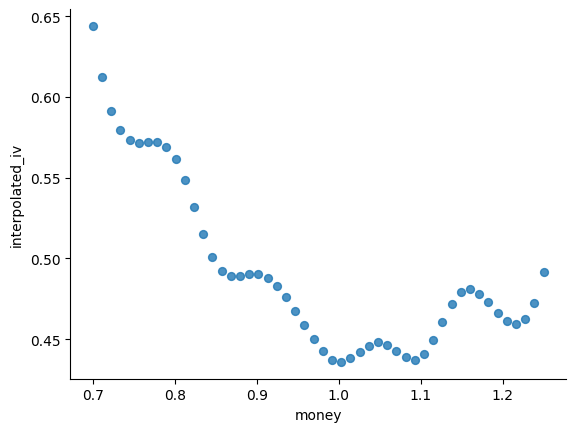

In [11]:
from matplotlib import pyplot as plt
interpolated_iv_1week = interpolated_iv[(interpolated_iv['year'] == 2022) & (interpolated_iv['week'] == 13)]

interpolated_iv_1week.plot(kind='scatter', x='money', y='interpolated_iv', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [12]:
# Example plot (using altair):
import altair as alt
alt.Chart(interpolated_iv_1week).mark_line().encode(
     x='money',
     y='interpolated_iv',
     color='week:N'
 ).facet(row='year:N')

alt.FacetChart(...)

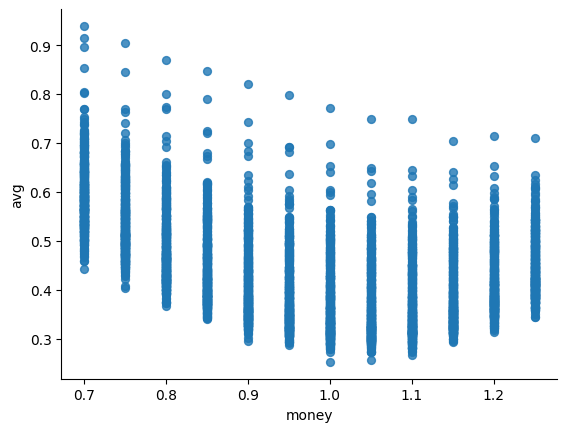

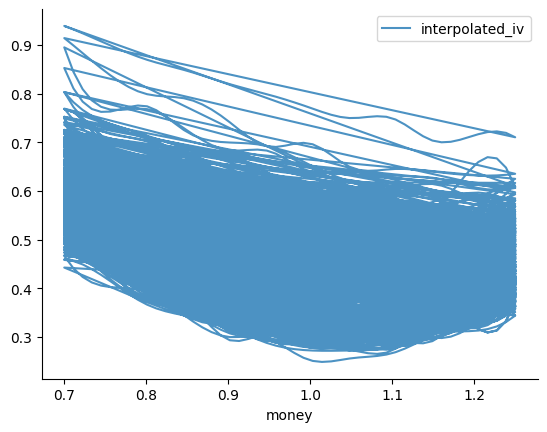

In [13]:

# Before interpolation
original_iv_call.plot(kind='scatter', x='money', y='avg', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# After interpolation
interpolated_iv.plot(kind='line', x='money', y='interpolated_iv', alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

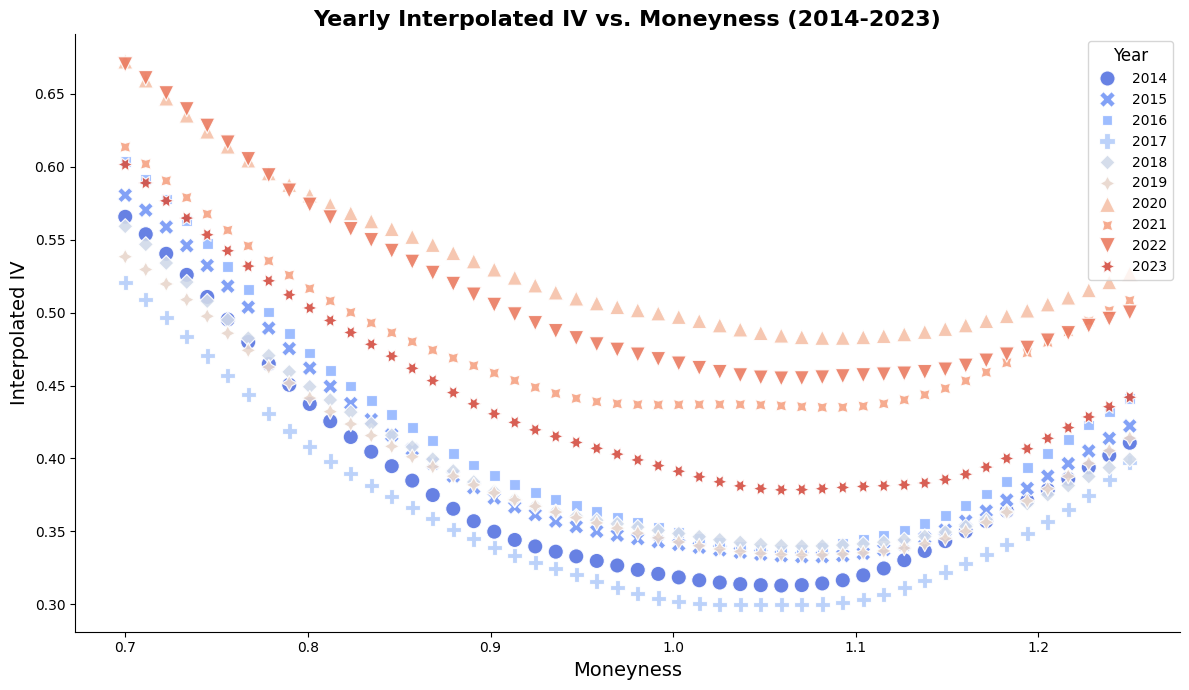

In [16]:

interpolated_iv['date'] = pd.to_datetime(interpolated_iv['year'].astype(str) + '-W' + interpolated_iv['week'].astype(str) + '-1', format='%Y-W%W-%w')

# Ensure 'date' column is in datetime format
interpolated_iv['date'] = pd.to_datetime(interpolated_iv['date'])

# Create 'quarter' column (if needed for future analysis)
interpolated_iv['quarter'] = interpolated_iv['date'].dt.quarter

# Group by year and moneyness, then calculate the average interpolated IV
average_iv = interpolated_iv.groupby(['year', 'money'])['interpolated_iv'].mean().reset_index()

# Get the range of years for the title
year_range = f"{average_iv['year'].min()}-{average_iv['year'].max()}"

# Convert year to a categorical variable sorted by year
average_iv['year'] = pd.Categorical(average_iv['year'], categories=sorted(average_iv['year'].unique()), ordered=True)

# Set up the plot
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=average_iv,
    x='money',
    y='interpolated_iv',
    hue='year',
    palette='coolwarm',  # Adjusted palette for better distinction
    style='year',
    s=120,  # Slightly larger marker size for better visibility
    alpha=0.9
)

# Add titles and labels
plt.title(f'Yearly Interpolated IV vs. Moneyness ({year_range})', fontsize=16, fontweight='bold')
plt.xlabel('Moneyness', fontsize=14)
plt.ylabel('Interpolated IV', fontsize=14)

# Remove top and right spines
sns.despine()

# Customize the legend
plt.legend(
    title='Year',
    loc='upper right',  # Moved to the left for better readability
    fontsize=10,
    title_fontsize=12
)

# Optimize layout for cleaner spacing
plt.tight_layout()

# Show the plot
plt.show()


In [17]:

class BlackScholesOption:
    def __init__(self, market_data, year, week, maturity_year, maturity_week, impliedVol, S, moneyness, option_type='call', buy_sell='buy'):
        """
        Initialize the Black-Scholes Option parameters with moneyness.

        Args:
            market_data (pd.DataFrame): DataFrame with market data including risk-free rate and dividend yield.
            year (int): Year for which the option is priced.
            week (int): Week number for which the option is priced.
            maturity_year (int): Year of the option's expiration date.
            maturity_week (int): Week of the option's expiration date.
            impliedVol (pd.DataFrame): DataFrame with implied volatilities.
            S (float): Current stock price.
            moneyness (float): Moneyness level to calculate the strike (e.g., 1.0 for ATM, 1.2 for 20% OTM).
            option_type (str): 'call' or 'put'.
            buy_sell (str): 'buy' for long option, 'sell' for short option.
        """
        self.year = year
        self.week = week
        self.maturity_year = maturity_year
        self.maturity_week = maturity_week

        # Calculate remaining time to maturity in years
        self.T = max((maturity_year - year) + (maturity_week - week) / 52, 0)  # Ensure non-negative

        target_data = market_data[(market_data['year'] == year) & (market_data['week'] == week)]
        if target_data.empty:
            raise ValueError(f"No market data available for year {year}, week {week}.")

        # Assign other parameters
        self.q = target_data['Div_yield_spy'].iloc[0]
        self.r = target_data['SOFR'].iloc[0] / 100  # Assuming SOFR is in percentage
        self.S = target_data['SPY'].iloc[0]   # Use the provided current stock price
        self.moneyness = moneyness
        self.K = self.S * self.moneyness  # Calculate strike price
        self.option_type = option_type.lower()
        self.buy_sell = buy_sell.lower()

        # Retrieve implied volatility for the current week or fallback
        filtered_sigma = impliedVol[(impliedVol['year'] == year) & (impliedVol['week'] == week)]
        if filtered_sigma.empty:
            week -= 1
            if week == 0:
                year -= 1
                week = 52
            print(f"No implied volatility found for year {year}, week {week}. Trying previous week.")
            filtered_sigma = impliedVol[(impliedVol['year'] == year) & (impliedVol['week'] == week)]

        closest_sigma_row = filtered_sigma.iloc[(filtered_sigma['money'] - moneyness).abs().argsort()[:1]]
        if closest_sigma_row.empty:
            raise ValueError(f"No implied volatility found for moneyness {moneyness} in year {year}, week {week}.")
        self.sigma = closest_sigma_row['interpolated_iv'].values[0]  # Assign the interpolated volatility

    def option_pricer(self, sigma=None):
        """
        Calculate the Black-Scholes price for the given volatility.

        Args:
            sigma (float, optional): Volatility (standard deviation of returns). Uses self.sigma if not provided.

        Returns:
            float: Option price.
        """
        sigma = sigma if sigma is not None else self.sigma
        if self.T == 0:
            intrinsic_value = max(0, (self.S - self.K)) if self.option_type == 'call' else max(0, (self.K - self.S))
            return intrinsic_value if self.buy_sell == 'buy' else -intrinsic_value

        d1 = (np.log(self.S / self.K) + (self.r - self.q + 0.5 * sigma ** 2) * self.T) / (sigma * np.sqrt(self.T))
        d2 = d1 - sigma * np.sqrt(self.T)

        if self.option_type == 'call':
            price = (self.S * np.exp(-self.q * self.T) * norm.cdf(d1) -
                     self.K * np.exp(-self.r * self.T) * norm.cdf(d2))
        elif self.option_type == 'put':
            price = (self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) -
                     self.S * np.exp(-self.q * self.T) * norm.cdf(-d1))
        else:
            raise ValueError("option_type must be 'call' or 'put'")

        return price if self.buy_sell == 'buy' else -price  # Apply buy/sell sign


class BufferETFStrategy:
    def __init__(self, market_data, creation_year, creation_week, maturity_year, maturity_week, impliedVol, S):
        """
        Initialize the Buffer ETF Strategy.

        Args:
            market_data (pd.DataFrame): DataFrame with market data.
            creation_year (int): Year of strategy creation.
            creation_week (int): Week of strategy creation.
            maturity_year (int): Year of option expiration.
            maturity_week (int): Week of option expiration.
            impliedVol (pd.DataFrame): DataFrame with implied volatilities.
            S (float): Current stock price.
        """
        self.market_data = market_data
        self.creation_year = creation_year
        self.creation_week = creation_week
        self.maturity_year = maturity_year
        self.maturity_week = maturity_week
        self.impliedVol = impliedVol
        self.T = max((maturity_year - creation_year) + (maturity_week - creation_week) / 52, 0)  # Ensure non-negative
        target_data = market_data[(market_data['year'] == year) & (market_data['week'] == week)]
        if target_data.empty:
            raise ValueError(f"No market data available for year {year}, week {week}.")
        self.S = target_data['SPY'].iloc[0]  # Use the provided current stock price

    def find_zero_moneyness(self):
        """
        Calculate the moneyness for the short call option to make the strategy value zero.

        Returns:
            float: The moneyness for the short call.
        """
        put_long = BlackScholesOption(self.market_data, self.creation_year, self.creation_week,
                                      self.maturity_year, self.maturity_week, self.impliedVol, self.S,
                                      moneyness=1.0, option_type='put', buy_sell='buy')
        put_long_value = put_long.option_pricer()

        put_short = BlackScholesOption(self.market_data, self.creation_year, self.creation_week,
                                       self.maturity_year, self.maturity_week, self.impliedVol, self.S,
                                       moneyness=0.8, option_type='put', buy_sell='sell')
        put_short_value = put_short.option_pricer()


        def objective(x_moneyness):
            call_option = BlackScholesOption(self.market_data, self.creation_year, self.creation_week,
                                             self.maturity_year, self.maturity_week, self.impliedVol, self.S,
                                             moneyness=x_moneyness, option_type='call', buy_sell='sell')

            call_value = call_option.option_pricer()
            other_position = put_long_value + put_short_value

            return call_value + other_position
        sol = root_scalar(objective, bracket=[1.0, 1.5], method='bisect', rtol=1e-5)
        return sol.root if sol.converged else None

    def calculate_portfolio_value(self, valuation_year, valuation_week, moneyness_short_call):
        """
        Calculate the portfolio value for the given valuation year and week.

        Args:
            valuation_year (int): Year of valuation.
            valuation_week (int): Week of valuation.
            moneyness_short_call (float): Moneyness for the short call option.

        Returns:
            float: The total portfolio value.
        """
        time_to_maturity = max((self.maturity_year - valuation_year) + (self.maturity_week - valuation_week) / 52, 0)

        target_data = self.market_data[(self.market_data['year'] == valuation_year) &
                                       (self.market_data['week'] == valuation_week)]
        if target_data.empty:
            raise ValueError(f"Target Date - No market data available for year {valuation_year}, week {valuation_week}.")

        target_data_1 = self.market_data[(self.market_data['year'] == valuation_year) &
                                       (self.market_data['week'] == valuation_week-1)]
        if target_data_1.empty:
            valuation_week -= 1
            if valuation_week == 0:
                valuation_year -= 1
                valuation_week = 52
            target_data_1 = self.market_data[(self.market_data['year'] == valuation_year) &
                                       (self.market_data['week'] == valuation_week)]

        SPY_valuation_1 = target_data_1['SPY'].iloc[0]

        SPY_valuation = target_data['SPY'].iloc[0]


        put_long = BlackScholesOption(self.market_data, valuation_year, valuation_week,
                                      self.maturity_year, self.maturity_week, self.impliedVol, SPY_valuation,
                                      moneyness=1.0, option_type='put', buy_sell='buy')
        put_long_value = put_long.option_pricer()

        put_short = BlackScholesOption(self.market_data, valuation_year, valuation_week,
                                       self.maturity_year, self.maturity_week, self.impliedVol, SPY_valuation,
                                       moneyness=0.8, option_type='put', buy_sell='sell')
        put_short_value = put_short.option_pricer()

        call_short = BlackScholesOption(self.market_data, valuation_year, valuation_week,
                                        self.maturity_year, self.maturity_week, self.impliedVol, SPY_valuation,
                                        moneyness=moneyness_short_call, option_type='call', buy_sell='sell')
        call_value = call_short.option_pricer()

        # Calculate S&P futures value
        #print(f"Valuation year {valuation_year}, week {valuation_week}.")
        #print(f'put_long_value: {put_long_value}' )
        #print(f'put_short_value: {put_short_value}' )
        #print(f'call_value: {call_value}')
        # Total portfolio value
        portfolio_value = call_value + put_long_value + put_short_value
        return portfolio_value




In [18]:
import pandas as pd
from dateutil.relativedelta import relativedelta

def get_rebalancing_dates(start_date, end_date, option_expiry_months):
    """
    Returns a list of rebalancing dates (last business day of the month) based on the option expiry interval,
    including an extra rebalancing date at the end of the period to ensure that we calculate all dates in the target dates.

    Args:
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        option_expiry_months (int): Interval for option expiry in months.

    Returns:
        list: List of rebalancing dates as datetime.date objects.
    """
    rebalancing_dates = []
    current_date = pd.to_datetime(start_date).date()

    # Generate rebalancing dates at the last business day of months
    while current_date <= pd.to_datetime(end_date).date():
        # Get the last business day of the current month
        eom_date = (pd.Timestamp(current_date) + pd.offsets.BMonthEnd(0)).date()
        rebalancing_dates.append(eom_date)
        # Move forward by the option expiry interval
        current_date = eom_date + relativedelta(months=+option_expiry_months)

    # Add an extra rebalancing date after the end date
    last_rebalancing_date = rebalancing_dates[-1] + relativedelta(months=+option_expiry_months)
    extra_rebalancing_date = (pd.Timestamp(last_rebalancing_date) + pd.offsets.BMonthEnd(0)).date()
    rebalancing_dates.append(extra_rebalancing_date)

    return rebalancing_dates

def calculate_buffer_strategy_return(market_data, impliedVol, start_date, end_date, buffer_level, option_expiry_months):
    """
    Calculates weekly portfolio returns for a buffer strategy over a given date range.

    Args:
        market_data (pd.DataFrame): DataFrame with market data, including dates, prices, dividend yields, and risk-free rates.
        impliedVol (pd.DataFrame): DataFrame with implied volatilities for various moneyness levels, years, and weeks.
        start_date (str): Start date of the backtest ('YYYY-MM-DD').
        end_date (str): End date of the backtest ('YYYY-MM-DD').
        buffer_level (float): Cap level for the buffer strategy (e.g., 1.2 for 20% OTM).
        option_expiry_months (int): Option expiry duration in months.

    Returns:
        pd.DataFrame: A DataFrame with Date, PortfolioValue, and Change in OptionPortfolioValue columns.
    """
    # Convert start and end dates to datetime.date
    start_date = pd.to_datetime(start_date).date()
    end_date = pd.to_datetime(end_date).date()

    # Generate weekly evaluation dates (Fridays) and rebalancing dates
    evaluation_dates = pd.date_range(start=start_date, end=end_date, freq='W-FRI').date
    rebalancing_dates = get_rebalancing_dates(start_date, end_date, option_expiry_months)

    # Initialize variables
    spy_portfolio_values = []
    option_portfolio_values = []
    moneyness_cap_values = []
    current_rebalancing_date = rebalancing_dates.pop(0)
    next_rebalancing_date = rebalancing_dates.pop(0) if rebalancing_dates else None

    # Initialize strategy with the first pricing and maturity dates
    strategy = BufferETFStrategy(
        market_data=market_data,
        impliedVol=impliedVol,
        creation_year=current_rebalancing_date.isocalendar()[0],
        creation_week=current_rebalancing_date.isocalendar()[1],
        maturity_year=next_rebalancing_date.isocalendar()[0],
        maturity_week=next_rebalancing_date.isocalendar()[1],
        S=0  # Initial stock price
    )

    # Calculate initial moneyness using the buffer level
    current_moneyness = strategy.find_zero_moneyness()

    # Iterate over weekly evaluation dates
    for valuation_date in evaluation_dates:
        #print(valuation_date)
        # Check if we've passed the next rebalancing date
        if next_rebalancing_date and valuation_date >= next_rebalancing_date:
            # Update rebalancing dates
            current_rebalancing_date = next_rebalancing_date
            next_rebalancing_date = rebalancing_dates.pop(0) if rebalancing_dates else None

            # Update strategy with new option parameters
            strategy = BufferETFStrategy(
                market_data=market_data,
                impliedVol=impliedVol,
                creation_year=current_rebalancing_date.isocalendar()[0],
                creation_week=current_rebalancing_date.isocalendar()[1],
                maturity_year=next_rebalancing_date.isocalendar()[0],
                maturity_week=next_rebalancing_date.isocalendar()[1] if next_rebalancing_date else None,
                S=0
            )
            current_moneyness = strategy.find_zero_moneyness()

        # Calculate portfolio value for the current valuation date
        valuation_year = valuation_date.isocalendar()[0]
        valuation_week = valuation_date.isocalendar()[1]

        # Calculate option portfolio value
        option_portfolio_value = strategy.calculate_portfolio_value(
            valuation_year=valuation_year,
            valuation_week=valuation_week,
            moneyness_short_call=current_moneyness
        )
        moneyness_cap_values.append([valuation_date, current_moneyness])

        # Get SPY data for the valuation week
        spy_target_data = market_data[
            (market_data['year'] == valuation_year) & (market_data['week'] == valuation_week)
        ]
        if spy_target_data.empty:
            raise ValueError(f"No market data available for year {valuation_year}, week {valuation_week}.")

        SPY_valuation = spy_target_data['SPY'].iloc[0]

        # Get SPY data for the previous week
        prev_week = valuation_week - 1
        prev_year = valuation_year
        if prev_week == 0:
            prev_week = 52
            prev_year -= 1

        spy_prev_data = market_data[
            (market_data['year'] == prev_year) & (market_data['week'] == prev_week)
        ]
        if spy_prev_data.empty:
            raise ValueError(f"No market data available for previous year {prev_year}, week {prev_week}.")

        SPY_valuation_1 = spy_prev_data['SPY'].iloc[0]

        # Calculate intrinsic change in future
        future_intrinsic_value = SPY_valuation - SPY_valuation_1

        # Store values
        spy_portfolio_values.append([valuation_date, future_intrinsic_value])
        option_portfolio_values.append([valuation_date, option_portfolio_value])
        # print(f'option_portfolio_value: {option_portfolio_value}')
        # print(f'future_intrinsic change over week: {future_intrinsic_value}' )


    # Convert portfolio values to DataFrame
    portfolio_values_df = pd.DataFrame(spy_portfolio_values, columns=['Date', 'SPY_PortfolioValue'])
    option_portfolio_values_df = pd.DataFrame(option_portfolio_values, columns=['Date', 'OptionPortfolioValue'])
    moneyness_cap_values_pd = pd.DataFrame(moneyness_cap_values, columns=['Date', 'Moneyness'])

    # Calculate change in option portfolio value
    option_portfolio_values_df['Change_OptionPortfolioValue'] = option_portfolio_values_df['OptionPortfolioValue'].diff()

    # Merge portfolio values with changes in option portfolio
    portfolio_values_df = portfolio_values_df.merge(
        option_portfolio_values_df[['Date', 'Change_OptionPortfolioValue']],
        on='Date',
        how='left'
    )
    portfolio_values_df = portfolio_values_df.merge(
        moneyness_cap_values_pd[['Date', 'Moneyness']],
        on='Date',
        how='left'
    )

    portfolio_values_df['BufferETF_Portf'] = portfolio_values_df['Change_OptionPortfolioValue'] + portfolio_values_df['SPY_PortfolioValue']
    # Extract year and week information from the date
    portfolio_values_df['Date'] = pd.to_datetime(portfolio_values_df['Date'])
    portfolio_values_df['Year'] = portfolio_values_df['Date'].dt.isocalendar().year
    portfolio_values_df['Week'] = portfolio_values_df['Date'].dt.isocalendar().week

    return portfolio_values_df


In [19]:

# Add year and week columns
market_data['Date'] = pd.to_datetime(market_data['Date']).dt.date
market_data['year'] = market_data['Date'].apply(lambda x: x.isocalendar().year)
market_data['week'] = market_data['Date'].apply(lambda x: x.isocalendar().week)

# Parameters
start_date = '2015-01-02'
end_date = '2023-6-30'
buffer_level = 0.8  # Example buffer level (20% OTM cap)
option_expiry_months = 3  # option expiry duration in months
start_date_dt = pd.to_datetime(start_date).date()
#market_data['Date'] = pd.to_datetime(market_data['Date']).dt.date

normalized_snp_value_start_date = market_data.loc[market_data['Date'] == start_date_dt, 'SPY'].values[0]

# Normalize the S&P 500 values
market_data['SPY']  = (market_data['SPY'] / normalized_snp_value_start_date) * 100

# Calculate weekly returns
weekly_returns = calculate_buffer_strategy_return(
    market_data=market_data,
    impliedVol=interpolated_iv,
    start_date=start_date,
    end_date=end_date,
    buffer_level=buffer_level,
    option_expiry_months=option_expiry_months
)
weekly_returns['Moneyness'] = ((weekly_returns['Moneyness']-1)*4) *100
# print(weekly_returns)


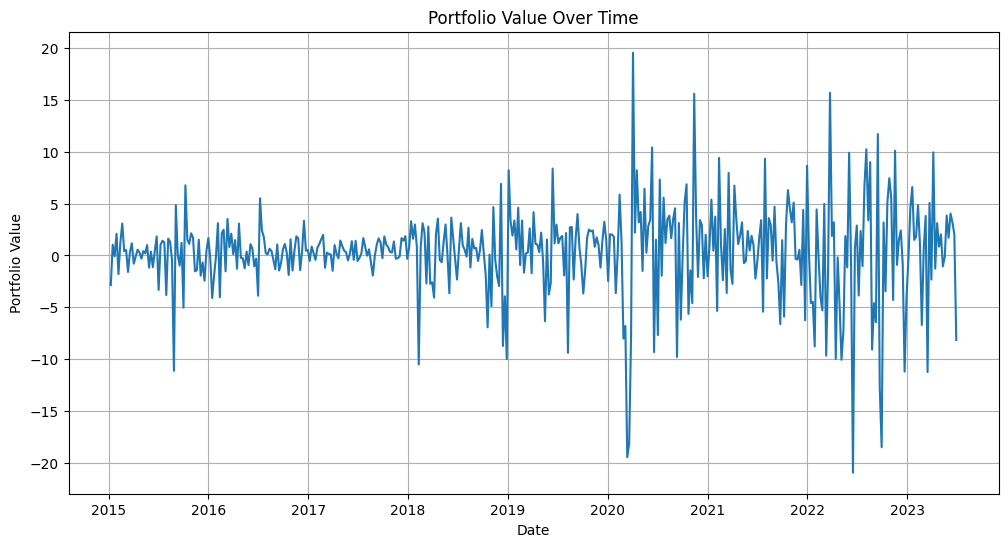

In [20]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_returns['Date'], weekly_returns['BufferETF_Portf'])
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.grid(True)
plt.show()

In [21]:
weekly_returns['Moneyness'].unique()

array([ 6.80236816,  8.93249512, 23.48937988,  9.48791504, 13.42468262,
       11.28845215, 15.0604248 , 13.22937012,  6.0333252 ,  6.93054199,
        8.95080566,  7.80944824, 10.24475098, 11.36169434, 17.48352051,
       21.90246582, 12.44812012, 28.39050293, 13.91296387,  9.83581543,
       55.2520752 , 25.9185791 , 30.02624512, 23.95935059, 24.03259277,
       14.7064209 , 16.94030762, 24.37438965, 30.4107666 , 31.43615723,
       43.87512207, 24.75891113, 48.36730957])

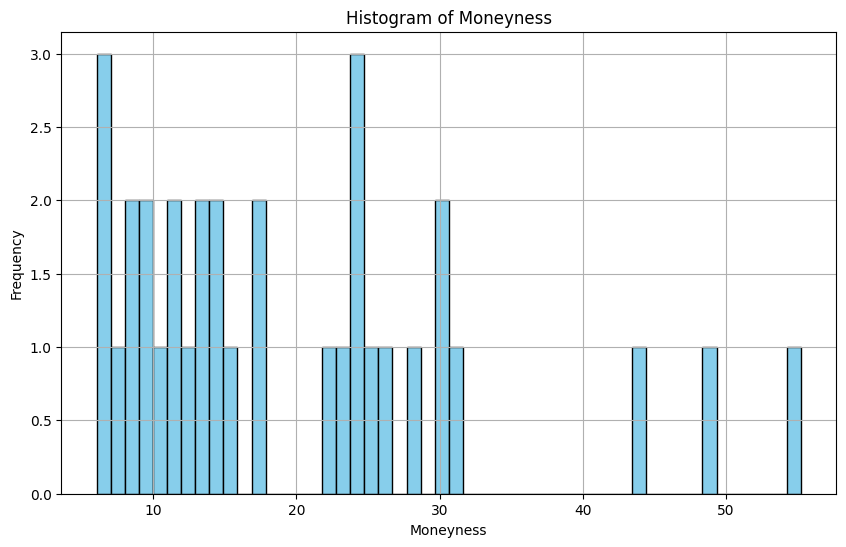

In [22]:
plt.figure(figsize=(10, 6))
plt.hist( weekly_returns['Moneyness'].unique(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Moneyness')
plt.ylabel('Frequency')
plt.title('Histogram of Moneyness')
plt.grid(True)
plt.show()

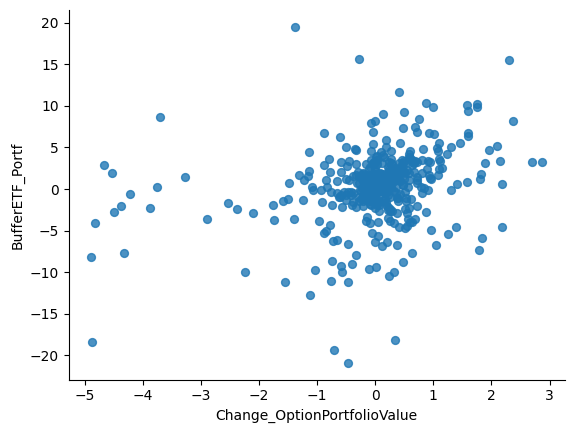

In [23]:

from matplotlib import pyplot as plt
weekly_returns.plot(kind='scatter', x='Change_OptionPortfolioValue', y='BufferETF_Portf', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

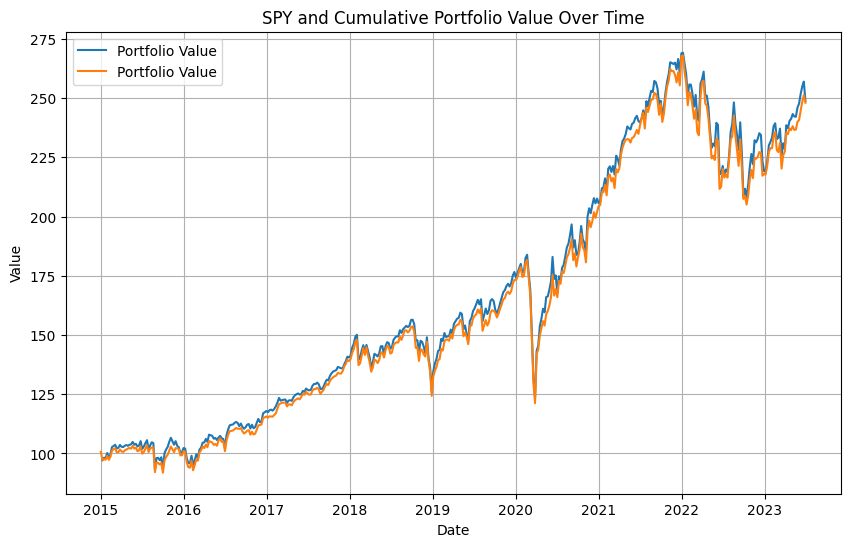

In [24]:

plt.figure(figsize=(10, 6))#
#plt.plot(market_data['Date'][:], market_data['SPY'][:], label='SPY')
plt.plot(weekly_returns['Date'][:], weekly_returns['BufferETF_Portf'][:].cumsum() + 100, label='Portfolio Value')
plt.plot(weekly_returns['Date'][:], weekly_returns['SPY_PortfolioValue'][:].cumsum() + 100, label='Portfolio Value')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SPY and Cumulative Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

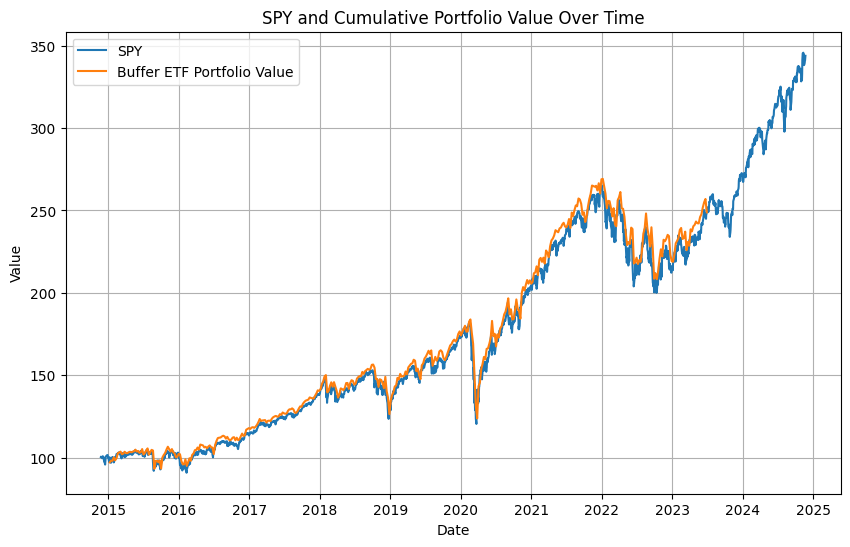

In [25]:

plt.figure(figsize=(10, 6))
plt.plot(market_data['Date'][:], market_data['SPY'][:], label='SPY')
plt.plot(weekly_returns['Date'][:], weekly_returns['BufferETF_Portf'][:].cumsum() + 100, label='Buffer ETF Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SPY and Cumulative Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()